In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


2025-12-05 00:15:54.800053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764893755.010319      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764893755.066192      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TF: 2.18.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
DATA_DIR = "/kaggle/input/dataset-head1/head1_dataset_split"
TRAIN_DIR = DATA_DIR + "/train"
VAL_DIR   = DATA_DIR + "/val"
TEST_DIR  = DATA_DIR + "/test"

IMG_SIZE   = 300
BATCH_SIZE = 16
SEED       = 42


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="binary",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    label_mode="binary",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode="binary",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)


Found 981 files belonging to 2 classes.


I0000 00:00:1764893772.483258      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764893772.483863      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 122 files belonging to 2 classes.
Found 125 files belonging to 2 classes.


In [4]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
], name="data_aug")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x,y: (data_aug(x), y)).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


In [5]:
base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid", name="head1_cattle")(x)

model_h1 = models.Model(inputs, outputs, name="Head1Model")
model_h1.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model_h1.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Head1Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head1_cattle (Dense)            │ (None, 1)              │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,785,072 (41.14 MB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [6]:
history = model_h1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)


Epoch 1/15


I0000 00:00:1764893793.290828      67 service.cc:148] XLA service 0x7ac9e4217480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764893793.291556      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764893793.291575      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764893796.199467      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/62 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.5625 - loss: 0.6603  

I0000 00:00:1764893810.940605      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 ━━━━━━━━━━━━━━━━━━━━ 78s 731ms/step - accuracy: 0.7581 - loss: 0.4935 - val_accuracy: 0.9180 - val_loss: 0.2330
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.9535 - loss: 0.2057 - val_accuracy: 0.9426 - val_loss: 0.1545
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 245ms/step - accuracy: 0.9748 - loss: 0.1323 - val_accuracy: 0.9590 - val_loss: 0.1163
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step - accuracy: 0.9857 - loss: 0.0981 - val_accuracy: 0.9754 - val_loss: 0.0989
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - accuracy: 0.9796 - loss: 0.0914 - val_accuracy: 0.9836 - val_loss: 0.0817
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.9779 - loss: 0.0751 - val_accuracy: 0.9836 - val_loss: 0.0736
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - accuracy: 0.9858 - loss: 0.0633 - val_accuracy: 0.9918 - val_loss: 0.0623
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - accuracy: 0.9873 - loss: 0.0659 - val_accuracy: 0.983

In [7]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model_h1.compile(
    optimizer=Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_ft = model_h1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 77s 700ms/step - accuracy: 0.9683 - loss: 0.0860 - val_accuracy: 0.9918 - val_loss: 0.0416
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.9793 - loss: 0.0657 - val_accuracy: 0.9918 - val_loss: 0.0439
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.9845 - loss: 0.0597 - val_accuracy: 0.9836 - val_loss: 0.0454
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.9912 - loss: 0.0397 - val_accuracy: 0.9918 - val_loss: 0.0427
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - accuracy: 0.9867 - loss: 0.0472 - val_accuracy: 0.9918 - val_loss: 0.0390
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.9926 - loss: 0.0368 - val_accuracy: 0.9918 - val_loss: 0.0376
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.9880 - loss: 0.0517 - val_accuracy: 0.9918 - val_loss: 0.0317
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.9891 - loss: 0.0368 - val_accu

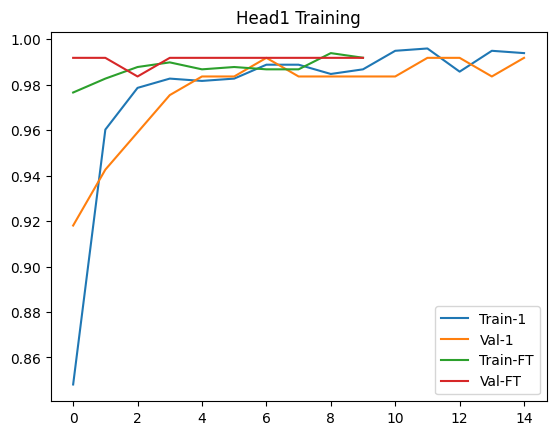

In [8]:
plt.plot(history.history["accuracy"], label="Train-1")
plt.plot(history.history["val_accuracy"], label="Val-1")
plt.plot(history_ft.history["accuracy"], label="Train-FT")
plt.plot(history_ft.history["val_accuracy"], label="Val-FT")
plt.legend()
plt.title("Head1 Training")
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0127
Test Accuracy: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        63
         1.0       1.00      1.00      1.00        62

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



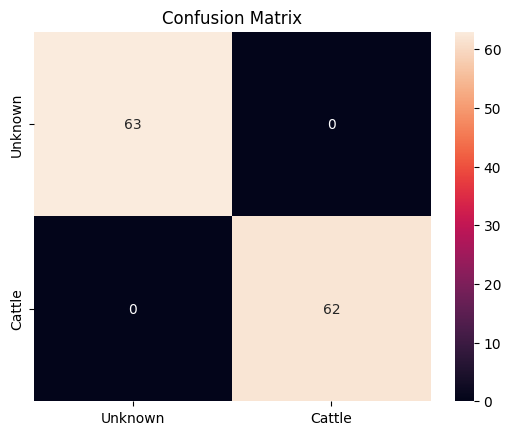

In [9]:
test_loss, test_acc = model_h1.evaluate(test_ds)
print("Test Accuracy:", test_acc)

y_true=[]
y_pred=[]

for imgs, labels in test_ds:
    preds = model_h1.predict(imgs)
    preds = (preds>0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=["Unknown","Cattle"],
            yticklabels=["Unknown","Cattle"])
plt.title("Confusion Matrix")
print(classification_report(y_true, y_pred))


In [10]:
feature_extractor = models.Model(
    inputs=model_h1.input,
    outputs=model_h1.layers[-2].output,
    name="FeatureExtractor"
)

x = feature_extractor.output

h1 = layers.Dense(1, activation="sigmoid", name="head1_cattle")(x)
h2 = layers.Dense(1, activation="sigmoid", name="head2_species")(x)
h3 = layers.Dense(30, activation="softmax", name="head3_cow_breeds")(x)
h4 = layers.Dense(10, activation="softmax", name="head4_buff_breeds")(x)

full_model = models.Model(
    inputs=feature_extractor.input,
    outputs=[h1, h2, h3, h4],
    name="PashuMultiHead"
)


In [11]:
new_h1 = full_model.get_layer("head1_cattle")
old_h1 = model_h1.get_layer("head1_cattle")

new_h1.set_weights(old_h1.get_weights())
print("Weights copied to full_model head1")


Weights copied to full_model head1


In [12]:
full_model.save("/kaggle/working/pashu_after_head1.h5")
print("Saved model => pashu_after_head1.h5")


Saved model => pashu_after_head1.h5


In [13]:
full_model.save("pashu_model_after_head1.h5")
